## **Notebook 09: Featurization with RDKit and Mordred**
### CBE 512. Machine Learning in Chemical Science and Engineering.

&#169; Princeton University

## Summary

In this notebook, we will be demonstrating *some* of the functionality of some common cheminformatics libraries that can be easily deployed with Python. I will note that `rdkit` provides many useful functions that have been long-used in the chemistry community, so it may be of more general utility to you than the simple functionality we demonstrate here.

This is, however, the first time we will encounter modules that are not native to Google Colab. We will see how to install these libraries on-the-fly. It takes some time, and it can be annoying. After this experience, you may be increasingly incentivized to start maintaining a Python distribution for use on your personal machine, rather than relying on Colab. Check back to the first lecture notes for some instructions as to how to accomplish this. It's not that bad and is probably a skill that will be useful to you.

In [2]:
# the following installs needed libraries that are not already available to us
!pip install rdkit-pypi
#!pip install 'mordred[full]'
!pip install 'mordredcommunity'

# comment: above installing mordredcommunity due to encountered incompatibility
# with numpy and some deprecation of np.float; other measures might be possible
# to ensure code works with mordred[full]. I don't know the ramifications of
# using the community code vs the initial version.
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 54.2 MB/s eta 0:00:00


### Required modules
Next, we will load all the modules necessary to run the notebook.



In [3]:
# Modules used by Prof. Webb in the notebook
# common python imports
import numpy  as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pydot
import graphviz

# machine learning imports
import tensorflow as tf
from tensorflow       import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as sklm

# Here are some new things related to cheminformatics
from rdkit import Chem
from rdkit.Chem import PandasTools as PT
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from mordred import Calculator, descriptors
from mordred.error import Missing

## **Importing some data**
The first we will do is just get our hands on some chemical structures to muck around with. We will use a dataset derived from the "Toxicology in the 21st Century" initiative. This contains qualitative toxicitity measurements for ~8000 compounds for 12 different targets (e.g., nuclear receptors and stress response pathways for different stuff). Use the following cell to load and preview the data. All of the columns beginning `NR-` or `SR-` are potential labels, while we plan to convert the `smiles` column into features

In [4]:
url_for_data = "https://raw.githubusercontent.com/webbtheosim/CBE512-MLinChmSciEng/main/data/tox21.csv"
data         = pd.read_csv(url_for_data,sep=",") # the data is already packaged as a .csv -- pandas can process this via the .read_csv method
data.head(8)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX6619,O=S(=O)(Cl)c1ccccc1
7,0.0,NaN,0.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,TOX25232,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1


## **Working with SMILES Strings**

In class, we discussed how the invention of SMILES strings was really motivated to provide a readable representation of a molecular graph. In the following cells, we are going to demonstrate the use of some utilities that convey that SMILES does indeed allow for that conversion. In particular, we are going to use `rdkit` to create drawings so we can get a better visual appreciation of the data, coupled with some property.

In [8]:
# here we are just selecting some data to look at, feel free to change label
label  = 'NR-AR'
exdata = data[['smiles',label]]

# these uses a tool within RDkit that will add a column to a pandas dataframe
# the new column will have label `ROMol` and contain an rdkit Mol object
PT.AddMoleculeColumnToFrame(exdata,smilesCol='smiles',includeFingerprints=False)
exdata.head()

[17:10:36] WARNING: not removing hydrogen atom without neighbors


,smiles,NR-AR,ROMol
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae97920>
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae95d90>
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,<rdkit.Chem.rdchem.Mol object at 0x79328ae95d20>
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae97680>
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae97530>


### inspecting the data...

Notice that some of the data above contains NaN -- probably because there is not data for that label for that molecule, or it is possibily irrelevant. This process is related to data curation. We have a couple of options to deal with values such as these. Here, we are simply going to eliminate these entries from the dataframe/exclude them from the dataset. This can lead to some bias. Another strategy would be data imputation/assigning default values, but that can also lead to bias... hmm. To be continued!

After obtaining a set of molecules that have actual properties, we make make a little diagram to illustrate the toxicity values along with the molecular structures.

In [9]:
print("Initially, I have {} molecules.".format(len(exdata)))
exdata= exdata[~exdata['ROMol'].isnull()]
nMol = len(exdata)
print("After curation, I have {} molecules.".format(nMol))
exdata= exdata[~exdata[label].isnull()]
nMol = len(exdata)
print("After curation, I have {} molecules.".format(nMol))
exdata.head(5)

Initially, I have 8014 molecules.
After curation, I have 8014 molecules.
After curation, I have 7439 molecules.


,smiles,NR-AR,ROMol
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae97920>
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae95d90>
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae97680>
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae97530>
5,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,<rdkit.Chem.rdchem.Mol object at 0x79328ae97a00>


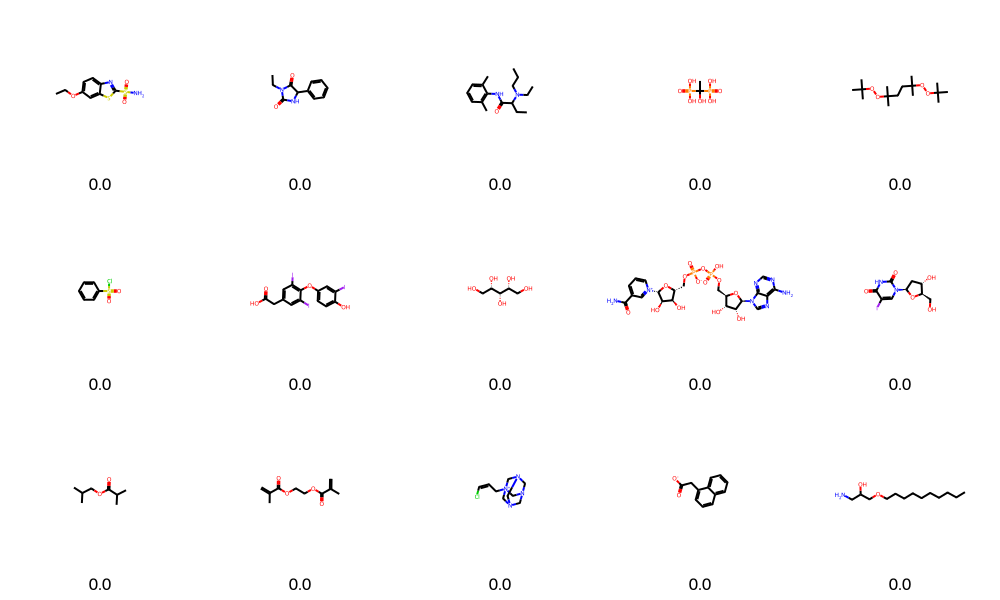

In [16]:
subset = exdata[label]>-1
display(PT.FrameToGridImage(exdata[subset].head(15), legendsCol=label, molsPerRow=5))

## **RDKit Molecules**

Now it's time to stop fooling around and get down to business. The first thing we are going to do is introduce how to convert SMILES into molecule objects in RDKit. Once we have a molecule object, RDKit can be used for many things. Is there any good way to know everything that can be done within RDKit? Historically, no... The documentation pages are improving with time, but you need to spend time with the doc pages, tutorial, and even use a little bit of trial-and-error/inspection yourself. For basic functionality, it's likely we can find the answer somewhere online.


Your chosen molecule is CC1=C(/C=C/C(C)=C/C=C\C(C)=C\C(=O)O)C(C)(C)CCC1

Here is our molecule object!


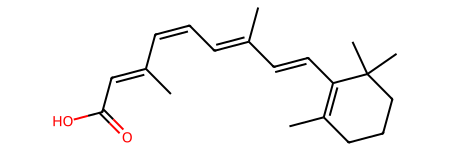


Let's enumerate all the methods/attributes known to Molecule!
AddConformer
ClearComputedProps
ClearProp
Compute2DCoords
ComputeGasteigerCharges
Debug
GetAromaticAtoms
GetAtomWithIdx
GetAtoms
GetAtomsMatchingQuery
GetBondBetweenAtoms
GetBondWithIdx
GetBonds
GetBoolProp
GetConformer
GetConformers
GetDoubleProp
GetIntProp
GetNumAtoms
GetNumBonds
GetNumConformers
GetNumHeavyAtoms
GetProp
GetPropNames
GetPropsAsDict
GetRingInfo
GetStereoGroups
GetSubstructMatch
GetSubstructMatches
GetUnsignedProp
HasProp
HasQuery
HasSubstructMatch
NeedsUpdatePropertyCache
RemoveAllConformers
RemoveConformer
SetBoolProp
SetDoubleProp
SetIntProp
SetProp
SetUnsignedProp
ToBinary
UpdatePropertyCache
__DebugMol
__GetSubstructMatch
__GetSubstructMatches
__class__
__copy__
__deepcopy__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__getinitargs__
__getstate__
__getstate_manages_dict__
__gt__
__hash__
__init__
__init_subclass__
__instance_size__
__le__
__lt__
__module__
__ne__
__ne

In [19]:
# let's pick a molecule
mID = int(np.random.rand()*nMol)
exampleStr = exdata['smiles'][mID]
print("Your chosen molecule is {}".format(exampleStr))

# this will create the molecule object from the string
exampleMol = Chem.MolFromSmiles(exampleStr)
print("\nHere is our molecule object!")
display(exampleMol)

# This is how we can check what methods are available to the molecule object
# (this may be good code to know in general for Python)
print("\nLet's enumerate all the methods/attributes known to Molecule!")
mol_methods = [method_name for method_name in dir(exampleMol)]
for mol_method in mol_methods:
    print(mol_method)


## **Unpacking molecules**

Of course, we also can appreciate that molecules are made of atoms. These atoms also have properties. Executing blocks like the following may be useful if you are trying to screen molecules for some specific kind of information. This could be used to create "descriptors" of the molecule. We will later use `mordred` to automatically compute many descriptors for us.

In [20]:
ringStuff = exampleMol.GetRingInfo()
for atom in exampleMol.GetAtoms():
    num = atom.GetAtomicNum()
    idx = atom.GetIdx()
    ri  = ringStuff.NumAtomRings(idx)
    print("Atom {} with atomic number {} is in {} rings".format(idx,num,ri))

Atom 0 with atomic number 6 is in 0 rings
Atom 1 with atomic number 6 is in 1 rings
Atom 2 with atomic number 6 is in 1 rings
Atom 3 with atomic number 6 is in 0 rings
Atom 4 with atomic number 6 is in 0 rings
Atom 5 with atomic number 6 is in 0 rings
Atom 6 with atomic number 6 is in 0 rings
Atom 7 with atomic number 6 is in 0 rings
Atom 8 with atomic number 6 is in 0 rings
Atom 9 with atomic number 6 is in 0 rings
Atom 10 with atomic number 6 is in 0 rings
Atom 11 with atomic number 6 is in 0 rings
Atom 12 with atomic number 6 is in 0 rings
Atom 13 with atomic number 6 is in 0 rings
Atom 14 with atomic number 8 is in 0 rings
Atom 15 with atomic number 8 is in 0 rings
Atom 16 with atomic number 6 is in 1 rings
Atom 17 with atomic number 6 is in 0 rings
Atom 18 with atomic number 6 is in 0 rings
Atom 19 with atomic number 6 is in 1 rings
Atom 20 with atomic number 6 is in 1 rings
Atom 21 with atomic number 6 is in 1 rings


## **Generating Molecular Fingerprints**

OK, so RDKit can be pretty useful for all kinds of random things (e.g., creating automated images of molecules, identifying substructures, and so on.) As it goes for machine learning, two areas of emphasis will be in generating fingerprints and molecular descriptors. RDKit offers a few different kind of fingerprints. The `RDKit fingerprint` is something akin to the `Daylight fingerprint` -- but it is not that. Meanwhile, you can also use `Morgan fingerprints`. Below we will demonstrate the generation of these fingerprints while adding a second example molecule so we can compute similarities.

CC1=C(/C=C/C(C)=C/C=C\C(C)=C\C(=O)O)C(C)(C)CCC1


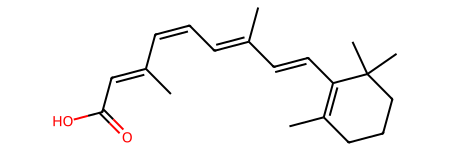

CC(C)CCCCOC(=O)c1ccccc1C(=O)OCCCCC(C)C


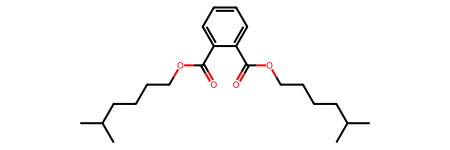

O=S(=O)(O)c1ccc2[nH]c(-c3ccccc3)nc2c1


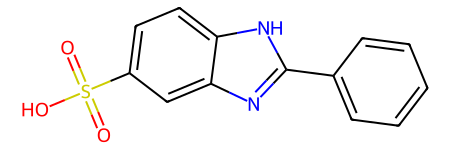

In [21]:
# generate molecules and look at, nay, admire them
mID2 = int(np.random.rand()*nMol)
exampleStr2 = exdata['smiles'][mID2]
exampleMol2 = Chem.MolFromSmiles(exampleStr2)
mID3 = int(np.random.rand()*nMol)
exampleStr3 = exdata['smiles'][mID3]
exampleMol3 = Chem.MolFromSmiles(exampleStr3)
print(exampleStr)
display(exampleMol)
print(exampleStr2)
display(exampleMol2)
print(exampleStr3)
display(exampleMol3)

[18:38:30] DEPRECATION WARNING: please use MorganGenerator
[18:38:30] DEPRECATION WARNING: please use MorganGenerator
[18:38:30] DEPRECATION WARNING: please use MorganGenerator


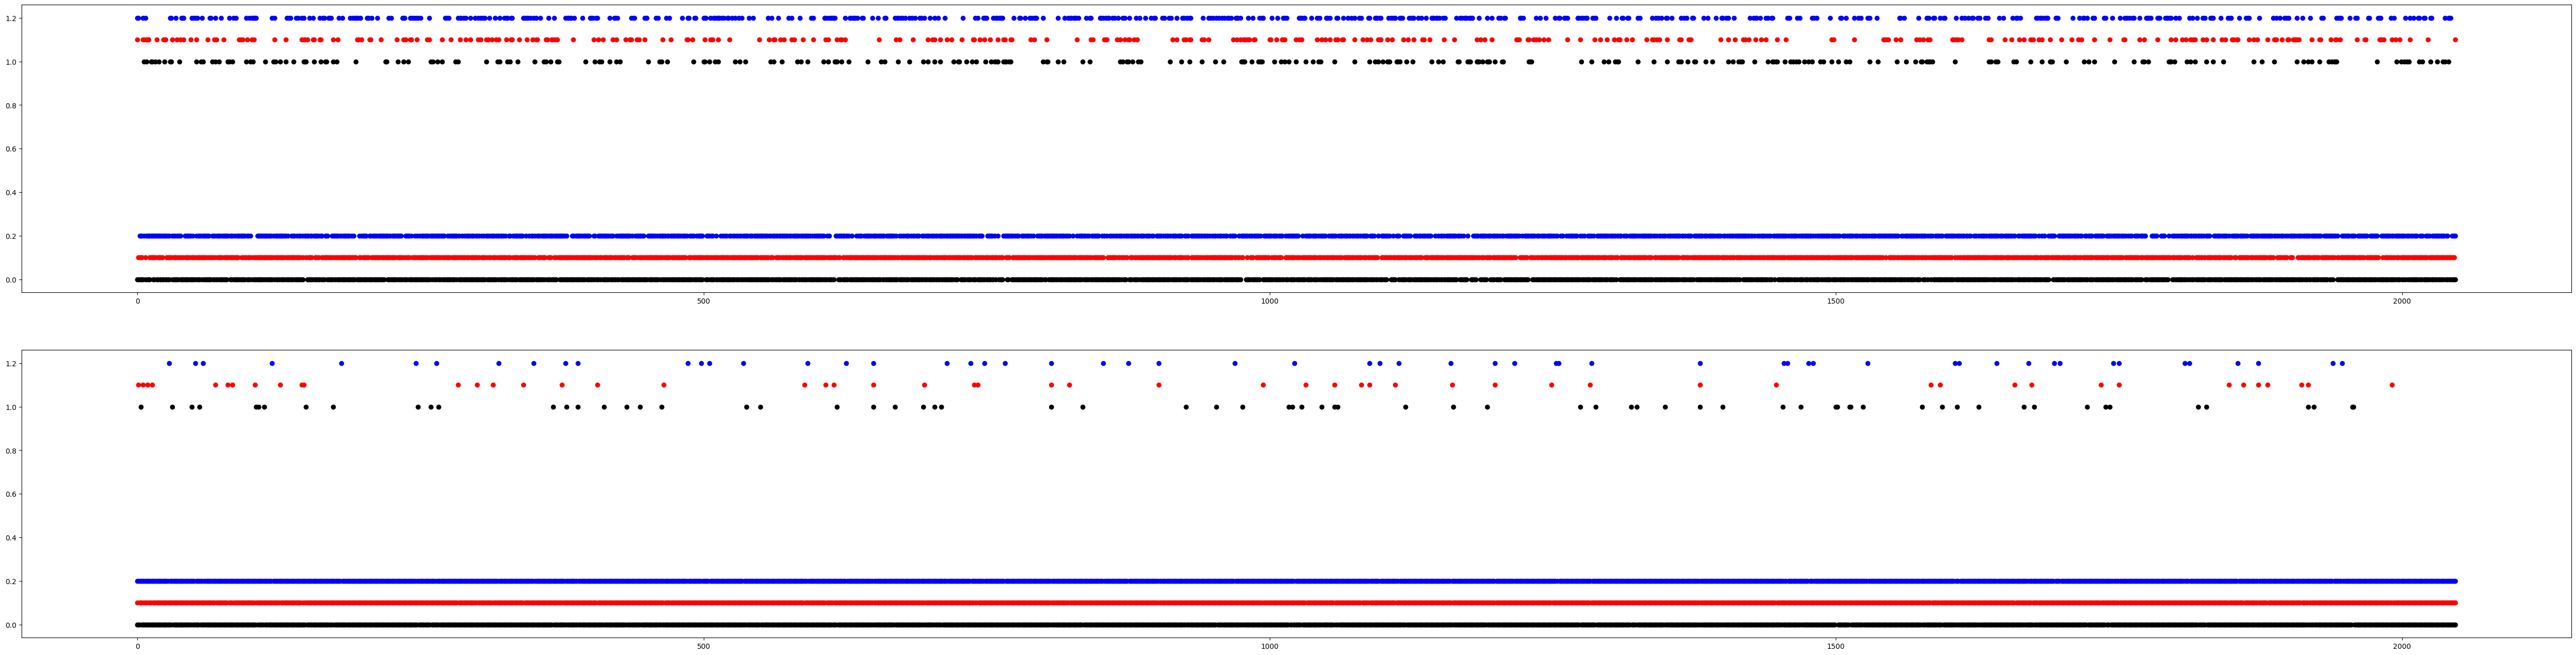

In [23]:
# Now we will create fingerprints.
mols = [exampleMol, exampleMol2, exampleMol3] # just a list of molecule objects

# Create fingerprint objects
# fingerprint objects contain a set of operations; because fps may be sparse
# they are packaged in classes that may not be directly usable for ML applications
# we can convert them to numpy arrays though if that is our purpose

# These are the fingerprints
RDfps= [Chem.RDKFingerprint(m) for m in mols] # list of RDKit fingerprints
Mfps = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m,6) for m in mols]

# these are output to numpy arrays
RDvecs = [np.array(fp) for fp in RDfps]
Mvecs  = [np.array(fp) for fp in Mfps ]

# We can see that these fingerprints are very different
fig,ax = plt.subplots(2,1)
fig.set_size_inches(64,16)
ax[0].plot(RDvecs[0],'ok')
ax[0].plot(RDvecs[1]+0.1,'or')
ax[0].plot(RDvecs[2]+0.2,'ob')
ax[1].plot(Mvecs[0],'ok')
ax[1].plot(Mvecs[1]+0.1,'or')
ax[1].plot(Mvecs[2]+0.2,'ob')
plt.show()

## **Similarity Calculations**
One thing that can be useful is to express measures of similarity for molecules. There are numerous metrics that are floating around for doing things of this kind. As far as their documentation reports, RDKit enables facile calculation of the following similarity metrics: `Tanimoto, Dice, Cosine, Sokal, Russel, Kulczynski, McConnaughey, and Tversky`
Inspecting the methods under `DataStructs` seems to suggest that they have even more beyond this.

In the following, we will make a comparison of similarities for some different metrics, as well as the different fingerprints.

In [24]:
from rdkit import DataStructs
metType   = ['Tanimoto', 'Dice', 'Cosine', 'Sokal', 'Russel', 'Kulczynski','McConnaughey']
simScoresRD = np.zeros((len(metType),3,3))
simScoresMF = np.zeros((len(metType),3,3))

# ordinarily you would invoke a call to the method like
# DataStructs.FingerprintSimilarity(Mfps[0],Mfps[1],   metric=DataStructs.DiceSimilarity)
# to iterate over the strings contained within metType, I will recognize that this things are classes with attributes
for i,metric in enumerate(metType):
    metricName = metric + "Similarity"
    for j in range(3):
      for k in range(3):
         simScoresRD[i,j,k] = DataStructs.FingerprintSimilarity(RDfps[j],RDfps[k], metric=getattr(DataStructs,metricName))
         simScoresMF[i,j,k] = DataStructs.FingerprintSimilarity(Mfps[j],Mfps[k], metric=getattr(DataStructs,metricName))

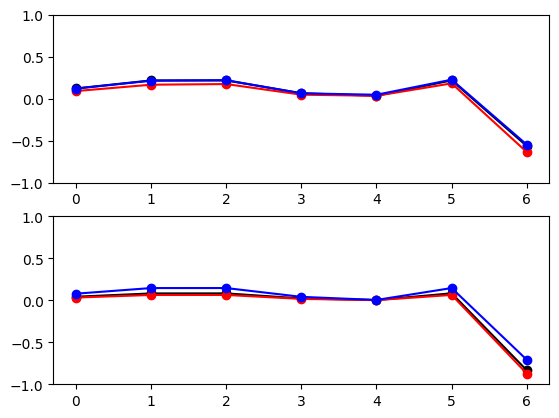

In [25]:
# look at how similarities compare for a couple of pairs
fig,ax = plt.subplots(2,1)
ax[0].plot(simScoresRD[:,0,1],'-ok')
ax[0].plot(simScoresRD[:,0,2],'-or')
ax[0].plot(simScoresRD[:,1,2],'-ob')
ax[0].set_ylim([-1,1])
ax[1].plot(simScoresMF[:,0,1],'-ok')
ax[1].plot(simScoresMF[:,0,2],'-or')
ax[1].plot(simScoresMF[:,1,2],'-ob')
ax[1].set_ylim([-1,1])
plt.show()


## **Descriptors in RDKit**
From molecule objects, we can also compute descriptors using RDKit. There are probably a zillion ways to go about doing this but there is a reasonable module `rdkit.Chem.rdMolDescriptors` that has a list of different things that can be computed. These can range from simple functions of connectivity/chemistry to geomteric descriptions and approximate surface area calculations; some don't even have documentation but still exists. We will just demonstrate a couple of these.

[18:45:29] WARNING: not removing hydrogen atom without neighbors


Examples of LASA


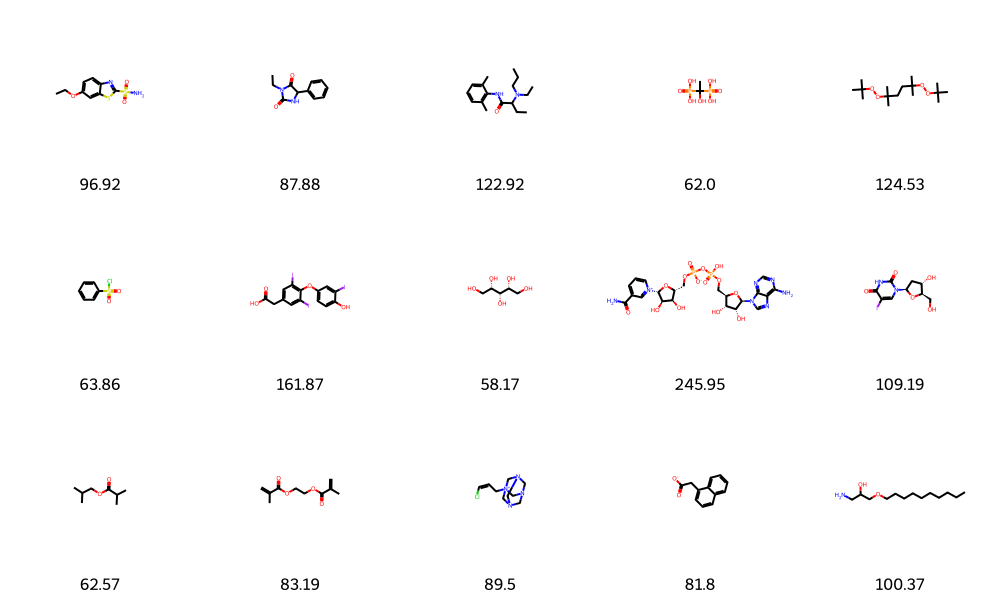


 Examples of Number of Rings


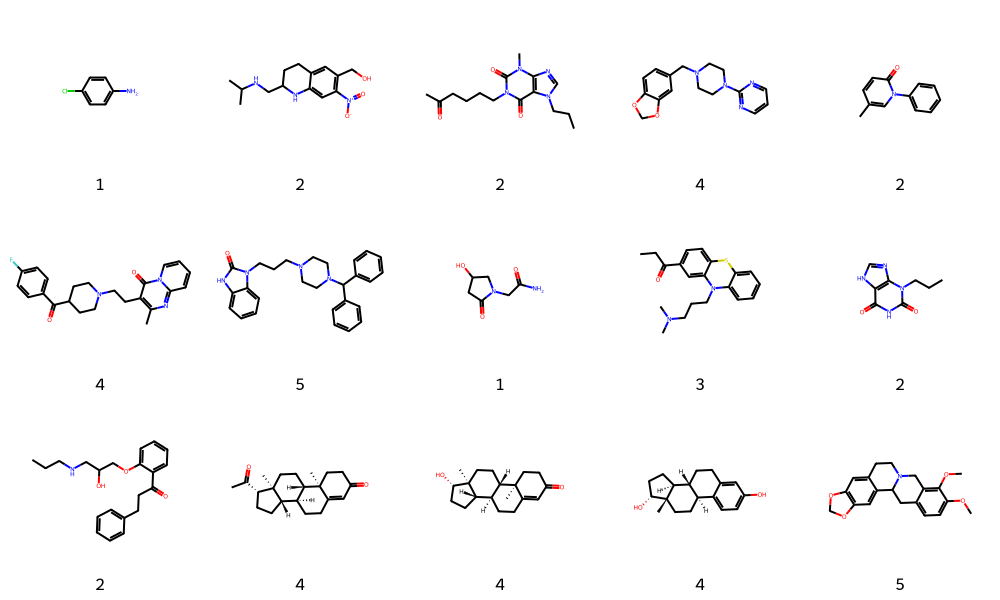

In [26]:
# Below we compute the "Labute Accessible Surface Area", Number of Rings, and Number of Rotatable bonds
LASA = [0.0 for i in range(exdata.shape[0])]
NR   = [0.0 for i in range(exdata.shape[0])]
NRB  = [0.0 for i in range(exdata.shape[0])]
for i,smiles in enumerate(exdata['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    LASA[i] = np.round(Chem.rdMolDescriptors.CalcLabuteASA(mol),2)
    NR[i]   = Chem.rdMolDescriptors.CalcNumRings(mol)
    NRB[i]  = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)

exdata['LASA'] = LASA
exdata['NR']  = NR
exdata['NRB'] = NRB
pd.options.display.float_format = "{:,.2f}".format
print("Examples of LASA")
display(PT.FrameToGridImage(exdata.head(15), legendsCol='LASA', molsPerRow=5))
print("\n Examples of Number of Rings")
display(PT.FrameToGridImage(exdata.tail(15), legendsCol='NR', molsPerRow=5))

## **Descriptors in Mordred**
So whilst RDKit supplies a lot of functionality in terms of computing these various descriptors, but honestly, it is a bit cumbersome. That's where Mordred comes in. In the following, we will import the mordred calculator and some list of descriptors and apply that to the data in the pandas dataframe. Mordred computes all the descriptors available in RDKit (or claims to) as well as some others. Running the below cell may take a few minutes, since there are *a lot* (1500+) descriptors.

In [14]:
calculator = Calculator(descriptors,ignore_3D=True)
wdesc = calculator.pandas(exdata['ROMol'])

  1%|          | 54/7439 [00:11<41:06,  2.99it/s][17:11:27] WARNING: not removing hydrogen atom without neighbors
[17:11:27] WARNING: not removing hydrogen atom without neighbors
[17:11:27] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 7439/7439 [27:55<00:00,  4.44it/s]


## **Data curation (again)**

Here, we are considering creating vectors to represent our molecules based on these descriptors. What if some don't exist? What do we do? Just as we need to consider this question for labels, we likewise need to consider it for features. Here, we are simply going to eliminate any features that have missing values for any molecule -- then we will proceed with the resulting subset. How many do we end up with?

In [27]:
# the below will prune away any descriptors that did not have valid calculations
from mordred.error import Missing
missing = []
for column in wdesc.columns:
    if (wdesc[column].apply(lambda x: type(x) == Missing)).any():
        missing.append(column)
wdesc = wdesc.drop(missing,axis=1)
wdesc.head()



,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,12.40,10.85,0,0,9,10,26,16,0,0,...,6.86,9.70,62.63,258.01,9.92,442,22,84.00,97.00,3.44
1,11.37,10.50,0,0,6,6,27,15,0,0,...,7.00,9.55,61.31,204.09,7.56,353,22,76.00,90.00,3.44
3,14.31,13.61,0,1,6,6,48,20,0,0,...,0.00,9.65,52.83,276.22,5.75,830,30,92.00,105.00,4.86
4,8.15,8.72,4,0,0,0,19,11,0,0,...,0.00,9.68,42.37,205.97,10.84,136,18,56.00,64.00,2.12
5,15.02,13.98,0,0,0,0,54,20,0,0,...,0.00,9.67,53.10,290.25,5.37,934,21,98.00,100.00,4.00


## **Predicting Class from Descriptors using Random Forest**
Below we will demonstrate the construction of a random forest classifier that decides the class of whatever toxicity value we picked based on the set of descriptors. In addition to showing the confusion matrix, we also indicate the area under a ROC curve as another metric of model accuracy. We did not discuss ROC in class, but a perfect classifier has an area of 1.0 under the ROC curve.

In [28]:
labels  = np.array(exdata[label]).reshape([-1,1])
features= np.array(wdesc)
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size = 0.2)
RFC = RandomForestClassifier(n_estimators=200)
RFC.fit(X_train,y_train)
y_pred = np.squeeze(RFC.predict(X_test))
p_pred = RFC.predict_proba(X_test)[:,1]
C = sklm.confusion_matrix(np.squeeze(y_test),y_pred)
roc = sklm.roc_auc_score(np.squeeze(y_test),p_pred)
print(C)
print(roc)

[[1427    2]
 [  35   24]]
0.7351591132829642


## **Predicting Class from Descriptors using a Neural Network**
We will see if we can achieve similar results by doing classification with a neural network. As a note, it is possible to build neural networks in scikit learn, and it is easy to do. However, I don't like them. Keras is is more powerful on the whole.

In [29]:
# Create Model Container
NNC = keras.Sequential(name="NNClassifier")

# Define Layers
inputLayer= keras.Input(shape=(wdesc.shape[1],))
hidden_neurons = [1000,500,250,100,50,20]
NNC.add(inputLayer)
for n in hidden_neurons:
    NNC.add(layers.Dense(n,activation='relu'))
output= layers.Dense(1,activation='sigmoid')
NNC.add(output)

# Admire Model
NNC.summary()

Model: "NNClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1000)                │         688,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │         125,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          25,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,344,941 (5.13 MB)

 Trainable params: 1,344,941 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Define Model optimization
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

myScaler  = MaxAbsScaler().fit(features)
Xsc_train = myScaler.transform(X_train)
Xsc_test  = myScaler.transform(X_test)
my_optimizer = keras.optimizers.Adam(learning_rate=0.001)
NNC.compile(optimizer=my_optimizer,loss="binary_crossentropy")
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=50)]
hist = NNC.fit(x=Xsc_train,y=y_train,
               epochs=500,
               batch_size=256,
               callbacks=my_callbacks,
               validation_split = 0.2,
               shuffle=True)

Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 0.3617 - val_loss: 0.1289
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.1453 - val_loss: 0.1202
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.1350 - val_loss: 0.1174
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1094 - val_loss: 0.1299
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1145 - val_loss: 0.1182
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0982 - val_loss: 0.1242
Epoch 7/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0991 - val_loss: 0.1174
Epoch 8/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1111 - val_loss: 0.1273
Epoch 9/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1098 - val_loss: 0.1167
Epoch 10/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0964 - val_loss: 0.1153
Epoch 11/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0886 - val_loss: 0.1251
Epoch 12/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/st

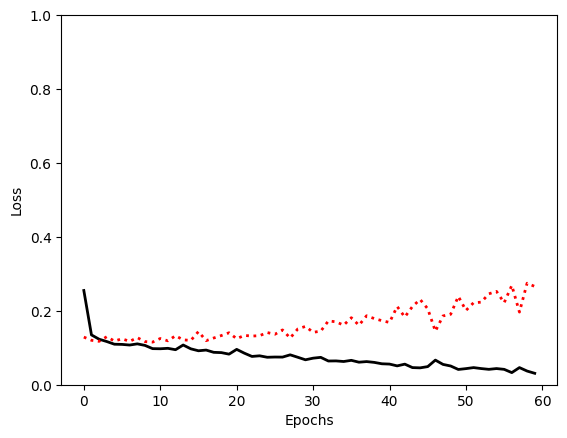

In [31]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss,'-k',linewidth=2)
plt.plot(val_loss,':r',linewidth=2)
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.show()

In [32]:
p_pred = NNC.predict(np.asarray(Xsc_test).astype('float32'))
y_pred = np.round(p_pred,0)
C = sklm.confusion_matrix(np.squeeze(y_test),y_pred)
roc = sklm.roc_auc_score(np.squeeze(y_test),p_pred)
print(C)
print(roc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[1418   11]
 [  35   24]]
0.716110590551648


The performance that we get for the NN classifier in Keras should be close to that of random forest. Note that we have not attempted to perform any kind of hyperparameter optimization -- so this is not a rigorous comparison! Nevertheless, early indications are that we can get the job done probably with either algorithm. Let's check out the scikit-learn implementation.

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[1000,500,250,100,50,20]).fit(Xsc_train, y_train)
(roc_auc_score(y_test, clf.predict_proba(Xsc_test)[:,1]), clf.score(Xsc_train,y_train),clf.score(Xsc_test,y_test))

(0.7148315232525759, 0.9931104016131742, 0.9623655913978495)

## **Using Fingerprints as Features**
In the previous few cells, our features were defined by a vector of descriptors, many of which are derived from the chemical structure. It would seem possible that we could train machine learning models to learn directly from a description of the chemical structure itself. Let's try it!

In [ ]:
fps = []
for i,smiles in enumerate(exdata['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    #fps.append(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,5))
    #fps.append(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,5,512))
    fps.append(Chem.RDKFingerprint(mol))

features = np.array(fps)
print(features.shape)

[17:09:29] WARNING: not removing hydrogen atom without neighbors


(7439, 2048)


As you can see above, the default size of the fingerprint is 2048-dimensions... that would necessitate a whole lot of parameters for our machine learning model. Let's take a look at one of these fingerprints.

In [ ]:
print(list(fps[0]))
print(list(fps[1]))

[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 

Hmmm, a lot of ones and zeros that indicate the presence or lack of some chemical substructure (roughly speaking)... It can sometimes be the case that *none* of the molecules in our dataset feature some substructures that might be described in this 2048-dimensional substructure, suggesting that this element is zero across our dataset. Conversely, perhaps it is possible that an element is always one for *all* of the molecules in the dataset. From an ML perspective, these input elements would never differ for any feature vector and thus represent a constant to the model. So we can screen for these to potentially reduce the dimensionality of the feature vector.

In [ ]:
# to figure out if there are any constant elements we will sum all of our fingerprints
# any bit that remains zero means that it is zero for everything
# any bit that equals the number of data points means it is one for everything
featureSum = np.sum(features,axis=0)
alwaysOn   = featureSum > features.shape[0]-0.01
alwaysOff  = featureSum < 0.5
print("There are {:>4d} elements that are always on".format(np.sum(alwaysOn)))
print("There are {:>4d} elements that are always off".format(np.sum(alwaysOff)))

There are    0 elements that are always on
There are    0 elements that are always off


Seems like this isn't the case here, indicating a pretty diverse set of structures. Now let's try out some learnin'

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size = 0.2)
clf = MLPClassifier(hidden_layer_sizes=[1000,500,250]).fit(X_train, y_train)
y_pred = np.round(clf.predict_proba(X_test)[:,1],0)
C = sklm.confusion_matrix(np.squeeze(y_test),y_pred)
print((roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]), clf.score(X_train,y_train),clf.score(X_test,y_test)))
print(C)

(0.7978334725703147, 0.9956309863888422, 0.9711021505376344)
[[1418    7]
 [  36   27]]
